# Nathalie MAVEL
Parcours DataScientist -- projet 7 : Implementing a scoring_model

The exploratory analysis was carried out thanks to the work of XXX. [date of consultation: 15/02/2022] . His entire analysis is available on Kaggle at the following link: .


- libraries 
- Read data


[1.Preprocessing](#section1)

- Imputer les valeurs manquantes,
- Transformer les booléens en intégrales,
- Centrer-réduire le jeu de données,
- Diviser le jeu de données en train test,
- Equilibrer les données.

[2. Modelisations](#section2)

- Logistic regression,
- Random Forest Classifier,
- LGB.


In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
# use of google drive and collab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
PATH_GENERAL = '/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model'

In [5]:
PATH_DATAS = PATH_GENERAL + '/DATAS'

In [6]:
# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [7]:
# transformations & metrics
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

# Read data

In [8]:
app_test_domain = pd.read_csv(PATH_GENERAL + '/app_test_domain_temp.csv')
app_train_domain = pd.read_csv(PATH_GENERAL + '/app_train_domain_temp.csv')

# 1. Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

def processing(df_train):
    
    # Drop the target from the training data
    if "TARGET" in df_train:
        train = df_train.drop(columns = ["TARGET"])
    else:
        train = df_train.copy()
        
    # Feature names
    features = list(train.columns)

    # Median imputation des valeurs manquantes (stratégie à expliciter lors de la présentation)
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to -1:1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Replace the boolean column by numerics values (la colonne que nous avons créées dans le preprocessing)
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)
    # test = imputer.transform(df_test)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    # test = scaler.transform(test)
    
    return train

In [10]:
def sampling(df_X, df_y):

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [11]:
# %%time
print("Preprocessing")
# imputer for handling missing values
from sklearn.impute import SimpleImputer
from collections import Counter
imputer = SimpleImputer(strategy = 'median')

train = processing(app_train_domain)
X_train, X_test, y_train, y_test = sampling(train, app_train_domain["TARGET"])

print('Original dataset shape %s' % Counter(app_train_domain["TARGET"]))


Preprocessing
Original dataset shape Counter({0: 282686, 1: 24825})


## Rebalance the target on the training set. 

Vu le nombre de données, nous allons pratiquer un undersampling ( avantages : *le* temps de calcul sera moins long et le dataset est très grand)

In [12]:
# Ressampling
import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter
us = RandomUnderSampler()

In [13]:
print("Undersampling")
X_us, y_us = us.fit_resample(X_train,  y_train)
print('Resampled dataset shape %s' % Counter(y_us))

Undersampling
Resampled dataset shape Counter({0: 19860, 1: 19860})


Class 0: 226148
Class 1: 19860
Proportion: 11.39 : 1


([<matplotlib.patches.Wedge at 0x7fe62ef9d5d0>,
 [Text(-0.27599847803582855, -1.0648121149394885, 'Classe 0'),
  Text(0.3010891943873195, 1.1616132303926274, 'Classe 1')],
 [Text(-0.1505446243831792, -0.5808066081488118, '91.9%'),
  Text(0.17563536339260305, 0.6776077177290325, '8.1%')])

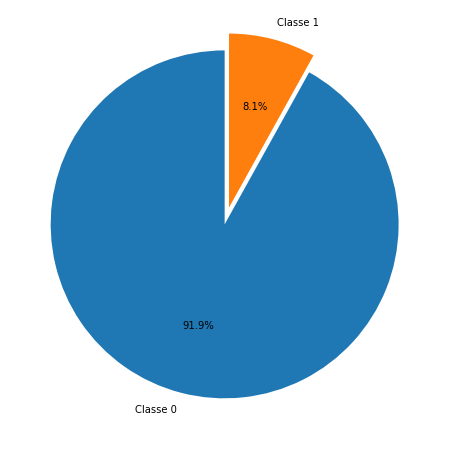

In [14]:
target_count =  y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=False, startangle=90,)

Class 0: 19860
Class 1: 19860
Proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x7fe62eacdbd0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'Classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

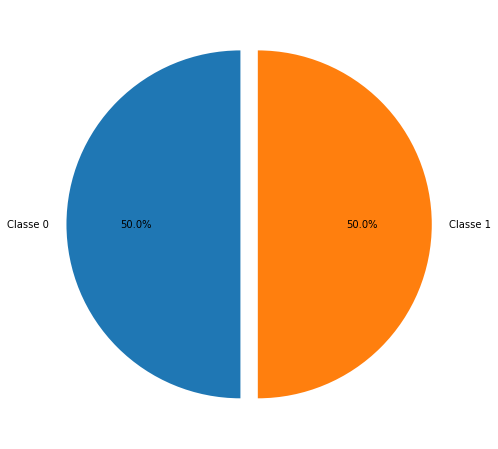

In [15]:
target_count =  y_us.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=False, startangle=90,)

In [16]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

# 2. Modélisation

fonction utilisées

In [17]:
# Fonction de cross validation de score personalisée qui renvoie aussi proba d'appartenir à la classe 1

def cv_score(clf, x, y, cv=5, beta=2):
    cv_score = []
    y_pred_proba = []

    # creation de folds pour CV
    kf = StratifiedKFold(n_splits=cv, shuffle = False)
    
    for train_indices, valid_indices in kf.split(x,y):
        
        # Entrainement pour le fold considéré
        X_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
        
        # Validation
        X_valid, y_valid = x.iloc[valid_indices], y.iloc[valid_indices]

        # Resampling       
        X_train, y_train = us.fit_resample(X_train, y_train)
        
        # Training
        clf.fit(X_train, y_train)

        # Prédiction sur jeu de test
        ypred = clf.predict(X_valid)
        
        # Sauvegarde des probas pour la classe 1
        yprob = clf.predict_proba(X_valid)
        y_pred_proba+=(list(yprob[:,1]))

        # Enregistrement des scores
        score = round(fbeta_score(y_valid, ypred, beta = beta), 3)
        
        cv_score.append(score)
    
    return np.array(cv_score), np.array(y_pred_proba)


In [18]:
#  régler le seuil utilisé pour mapper les probabilités aux étiquettes de classe.
#  fonction indiquant le seuil optimal qui maximise le score F2

def threshold_selection(y_proba, y_test):
    
    scores = []
    for threshold in np.linspace(0, 1, num=100):
        y_pred = y_proba > threshold
        score = fbeta_score(y_test, y_pred, beta = 2)
        scores.append(score) 

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    
    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=100), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()
    return best_threshold

In [19]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition ([random guessing on a classification task will score a 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [20]:
# Enregistrement des résultats dans un dataframe
df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

In [21]:
df_results.head()

,y_true
256571,0
191493,0
103497,0
130646,0
211898,0


In [22]:
#recherche sur grille des meilleurs paramètres du modèle

# Class_weight='balanced' == dataset équilibré
log_reg  = LogisticRegression(class_weight = 'balanced') 
ftwo_scorer = make_scorer(fbeta_score, beta=2)
# use a full grid over all parameters
grid_values = {'penalty': ['l1','l2'], 'C': [0.0001,0.001,0.01,0.1,1,10]}
#run grid search
grid = GridSearchCV(log_reg, param_grid=grid_values, cv=5, scoring = ftwo_scorer)
grid.fit(X_us, y_us)
print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'C': 10, 'penalty': 'l2'}
Best cross-validation score (F2-score)): 0.678


In [23]:
# On lance les prédictions

log_reg = LogisticRegression(C = 0.001, penalty = 'l2', class_weight = 'balanced')
log_reg.fit(X_us, y_us)

y_pred = log_reg.predict(X_test)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["log_reg_pred"] = log_reg_pred

df_results.head()

,y_true,log_reg_pred
256571,0,0.442063
191493,0,0.462458
103497,0,0.625832
130646,0,0.582317
211898,0,0.591464


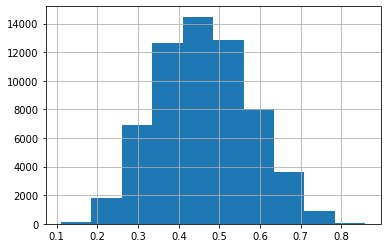

In [24]:
df_results["log_reg_pred"].hist()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Best Threshold : 0.49
Best Score : 0.36


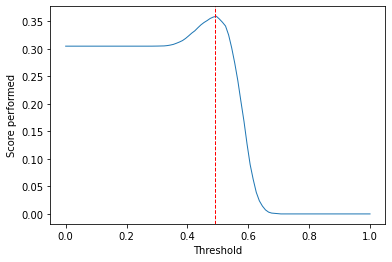

In [25]:
# Optimisation du seuil
clf_reg_bal = LogisticRegression(C = 0.001,
                        penalty = 'l2',
                        class_weight = 'balanced',
                        verbose=1)

X_test = pd.DataFrame(X_test)
y_proba = cv_score(clf_reg_bal, X_test, y_test, cv = 5, beta = 2)[1]

best_threshold = threshold_selection(y_proba, y_test)

In [26]:
df_results["y_pred_lr_bin"] = transform_treshold(df_results["log_reg_pred"], best_threshold)
df_results.head(25)

,y_true,log_reg_pred,y_pred_lr_bin
256571,0,0.442063,0
191493,0,0.462458,0
103497,0,0.625832,1
130646,0,0.582317,1
211898,0,0.591464,1
130549,0,0.561855,1
287975,0,0.304852,0
144906,0,0.220657,0
102173,0,0.679311,1
254495,1,0.371791,0


In [27]:
y_pred_proba = log_reg.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.723


## Random forest

In [28]:
%%time

# Make the model with the specified regularization parameter
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight = 'balanced')

# Train on the training data
clf_rf.fit(X_us, y_us)

# Make predictions
# Make sure to select the second column only
y_pred_proba_rf=[]
rf_pred = clf_rf.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_rf"] = rf_pred


CPU times: user 17 s, sys: 75.2 ms, total: 17 s
Wall time: 18.9 s


In [29]:
df_results.head()

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf
256571,0,0.442063,0,0.470527
191493,0,0.462458,0,0.376954
103497,0,0.625832,1,0.673064
130646,0,0.582317,1,0.571981
211898,0,0.591464,1,0.564713


Best Threshold : 0.49
Best Score : 0.394


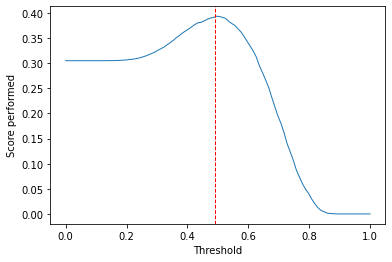

CPU times: user 19.3 s, sys: 183 ms, total: 19.5 s
Wall time: 19.4 s


In [30]:
%%time

# Optimisation du seuil 

clf_rf = RandomForestClassifier(n_estimators=100, 
                                max_depth=15,
                                class_weight = 'balanced')

X_test = pd.DataFrame(X_test)
y_proba = cv_score(clf_rf, X_test, y_test, cv = 5, beta = 2)[1]
best_threshold = threshold_selection(y_proba, y_test)

In [31]:
df_results["y_pred_rf_bin"] = transform_treshold(df_results["y_pred_rf"], best_threshold)

df_results.head()

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin
256571,0,0.442063,0,0.470527,0
191493,0,0.462458,0,0.376954,0
103497,0,0.625832,1,0.673064,1
130646,0,0.582317,1,0.571981,1
211898,0,0.591464,1,0.564713,1


In [32]:
y_pred_proba = clf_rf.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.907


## LGB

In [33]:
# %%time
# # Recherche sur grille des meilleurs paramètres du modèle

# lgbc = lgb.LGBMClassifier(random_state=2, class_weight = 'balanced')

# param_grid = {'objective' : ['binary'],
#              'boosting' : ['gbdt', 'dart', 'goss'],
#              'n_estimators': [250, 500, 750, 1000], 
#              'learning_rate' : [0.005, 0.01],
#              'max_depth' : [5, 10, 20, None],
#              'num_leaves' : [4, 16, 64, 128],
#              'min_data_in_leaf' : [100, 500], 
#              'reg_alpha' : [1,1.2, 1.4],
#              'reg_lambda' : [1,1.2,1.4]}

# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# grid = RandomizedSearchCV(lgbc, param_grid, n_iter = 50, cv = 5, scoring = ftwo_scorer, verbose=1)

# grid.fit(X_us, y_us)

# print("Grid-Search with F2-score")
# print("Best parameters:", grid.best_params_)
# print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Best Threshold : 0.44
Best Score : 0.394


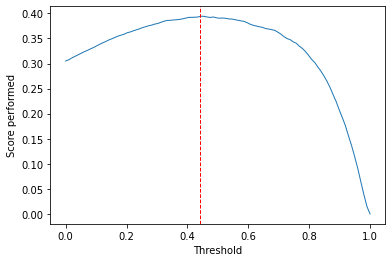

CPU times: user 2min 50s, sys: 1.37 s, total: 2min 51s
Wall time: 1min 29s


In [34]:
%%time

# Create the model
clf_lgb = lgb.LGBMClassifier(n_estimators=1000,
                             objective='binary',
                             class_weight='balanced',
                             learning_rate=0.05,
                             reg_alpha=0.1,
                             reg_lambda=0.1,
                             subsample=0.8,
                             n_jobs=-1,
                             random_state=0
                            )

# Train on the training data
clf_lgb.fit(X_us, y_us)

# Make predictions
# Make sure to select the second column only
lgb_pred = clf_lgb.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_lgb"] = lgb_pred

X_test = pd.DataFrame(X_test)

y_proba = cv_score(clf_lgb, X_test, y_test, cv = 5, beta = 2)[1]


# Optimisation du meilleure score
best_threshold = threshold_selection(y_proba, y_test)

In [35]:
# df_results.head()

In [36]:
df_results["y_pred_lgb_bin"] = transform_treshold(df_results["y_pred_lgb"], best_threshold)

In [37]:
df_results.head(20)

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin,y_pred_lgb,y_pred_lgb_bin
256571,0,0.442063,0,0.470527,0,0.456918,1
191493,0,0.462458,0,0.376954,0,0.419093,0
103497,0,0.625832,1,0.673064,1,0.869972,1
130646,0,0.582317,1,0.571981,1,0.318414,0
211898,0,0.591464,1,0.564713,1,0.467990,1
130549,0,0.561855,1,0.612837,1,0.661502,1
287975,0,0.304852,0,0.291765,0,0.179595,0
144906,0,0.220657,0,0.287216,0,0.048050,0
102173,0,0.679311,1,0.720945,1,0.877873,1
254495,1,0.371791,0,0.477009,0,0.538248,1


In [38]:
y_pred_proba = clf_lgb.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.914


# 3. Evaluation 

- Matrice de confusion

In [39]:
import sys
print(sys.getrecursionlimit())

1000


In [40]:
# sys.setrecursionlimit(30000)

In [41]:
df_evaluation = df_results.copy()

In [42]:
df_evaluation = df_evaluation.drop(['log_reg_pred', 'y_pred_rf', 'y_pred_lgb' ], axis=1)

In [43]:
df_evaluation.head(20)

,y_true,y_pred_lr_bin,y_pred_rf_bin,y_pred_lgb_bin
256571,0,0,0,1
191493,0,0,0,0
103497,0,1,1,1
130646,0,1,1,0
211898,0,1,1,1
130549,0,1,1,1
287975,0,0,0,0
144906,0,0,0,0
102173,0,1,1,1
254495,1,0,0,1


In [44]:
# permet de tracer la matrice de confusion
def confusion_matrix_plot(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    print('Confusion matrix:\n', conf_mat)

    labels = ['true', 'false']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predict values')
    plt.ylabel('Real values')
    plt.show()

y_true
Confusion matrix:
 [[56538     0]
 [    0  4965]]


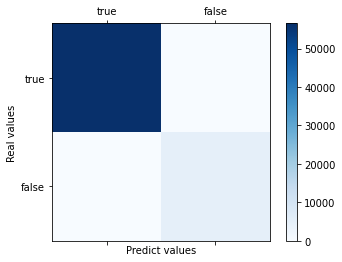

y_pred_lr_bin
Confusion matrix:
 [[35555 20983]
 [ 1513  3452]]


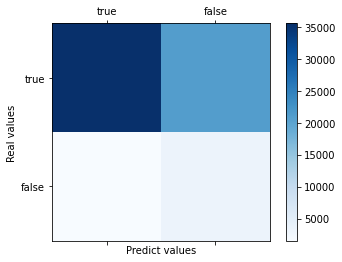

y_pred_rf_bin
Confusion matrix:
 [[37046 19492]
 [ 1471  3494]]


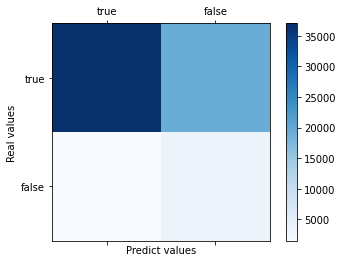

y_pred_lgb_bin
Confusion matrix:
 [[35091 21447]
 [ 1173  3792]]


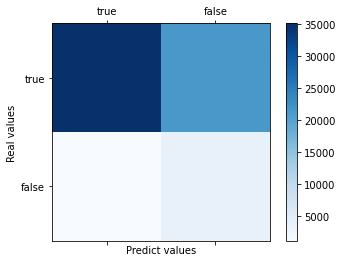

In [45]:
for i in df_evaluation.columns: 
  print(i)
  confusion_matrix_plot(df_evaluation['y_true'], df_evaluation[i])

## 3.2 Les métriques d'évaluation

- # fbetascore ==>  permet d'évaluer les Faux négatifs (à travers la pondération du paramètre) Cette mesure permet de définir combien le rappel est important par rapport à la précision.

https://towardsdatascience.com/is-f1-the-appropriate-criterion-to-use-what-about-f2-f3-f-beta-4bd8ef17e285

- precision : coeff determine que quand le classifieur déclate une prédiction à 1, il a raison à X %
- recall : coeff qui déterminee le pourcentage de détection des 1 du classifieur

F1 score, moyenne de la précision et du rappel, il accorde plus de poids aux faibles valeurs

In [46]:
df_results.head()

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin,y_pred_lgb,y_pred_lgb_bin
256571,0,0.442063,0,0.470527,0,0.456918,1
191493,0,0.462458,0,0.376954,0,0.419093,0
103497,0,0.625832,1,0.673064,1,0.869972,1
130646,0,0.582317,1,0.571981,1,0.318414,0
211898,0,0.591464,1,0.564713,1,0.467990,1


In [47]:
def result_metrics(i, j):
  df_m = pd.DataFrame()
  df_m.loc[i, 'accuracy' ] = round(accuracy_score(df_evaluation["y_true"], df_evaluation[j],), 3)
  df_m.loc[i, 'precision' ] = round(precision_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'recall' ] = round(recall_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'f1_score' ] = round(f1_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'f2_score' ] = round(fbeta_score(df_evaluation["y_true"], df_evaluation[j], beta = 2), 3)
  df_m.loc[i, 'f3_score' ] = round(fbeta_score(df_evaluation["y_true"], df_evaluation[j], beta = 3), 3)
  return df_m

In [48]:
df1 = result_metrics('LR', 'y_pred_lr_bin')
df2 = result_metrics('RF', 'y_pred_rf_bin')
df3 = result_metrics('LGBM', 'y_pred_lgb_bin')
frames = [df1, df2, df3]
df_result_metric = pd.concat(frames)

In [49]:
df_result_metric

,accuracy,precision,recall,f1_score,f2_score,f3_score
LR,0.634,0.141,0.695,0.235,0.390,0.499
RF,0.659,0.152,0.704,0.250,0.408,0.516
LGBM,0.632,0.150,0.764,0.251,0.420,0.542


précision et recall évolue de la même façon, une precision + faible que le recall ==> les scores F sont donc tous orientées de la même façon.

faire la courbe ROC

# 4. Save mode

In [50]:
import sklearn
import joblib
import pickle

with open('/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model/model_lgb.pickle', 'wb') as file :
    pickle.dump(clf_lgb, file)

# 4. interprétabilité globale

In [51]:
pip install shap==0.39

     |████████████████████████████████| 356 kB 4.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491669 sha256=6394644d1e256bd8bb3cd04cc3d2a8944d2a3e136a5a1aef3dace344770b89d5
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [52]:
# Import du module SHAP, initialisation et import du modèle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import matplotlib
shap.initjs()

In [59]:
matplotlib.__version__

'3.2.2'

In [63]:
shap.__version__

'0.39.0'

In [61]:
np.__version__

'1.21.6'

- Afficher shap par rapport au modele global
- afficher shap par rapport aux individus et par rapport à une variable importante

In [53]:
# Import du module SHAP, initialisation et import du modèle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

with open('/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model/model_lgb.pickle', 'rb') as file : 
    LGB = pickle.load(file)

In [54]:
app_test_domain.shape

(48744, 244)

--interprétation du modéle dans son esnsemble

       
LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=0, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)
CPU times: user 4.76 s, sys: 32.9 ms, total: 4.79 s
Wall time: 3.53 s


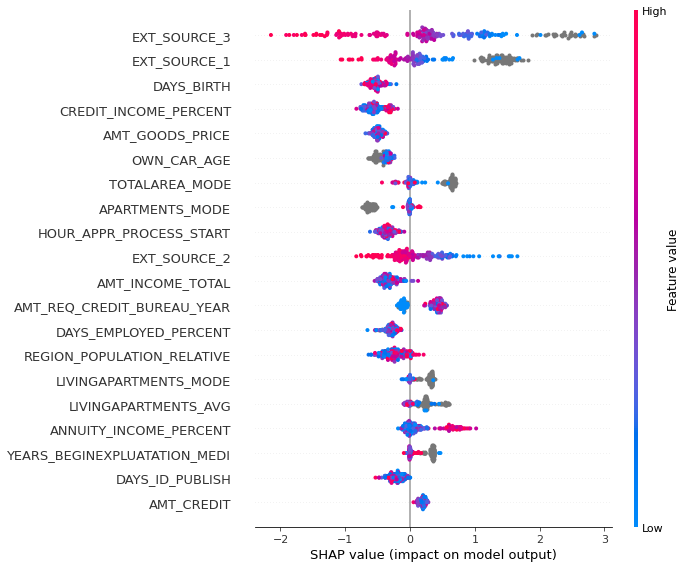

In [55]:
model_name = [LGB]

for m in model_name : 
  print('       ')
  print(m)

  X_test_sample = app_test_domain.head(200)
  explainer = shap.TreeExplainer(m, feature_perturbation="interventional", model_output="raw")
  shap_values = explainer.shap_values(X_test_sample)
  %time shap_values = shap.TreeExplainer(m).shap_values(X_test_sample)
  shap.summary_plot(shap_values[1], X_test_sample)

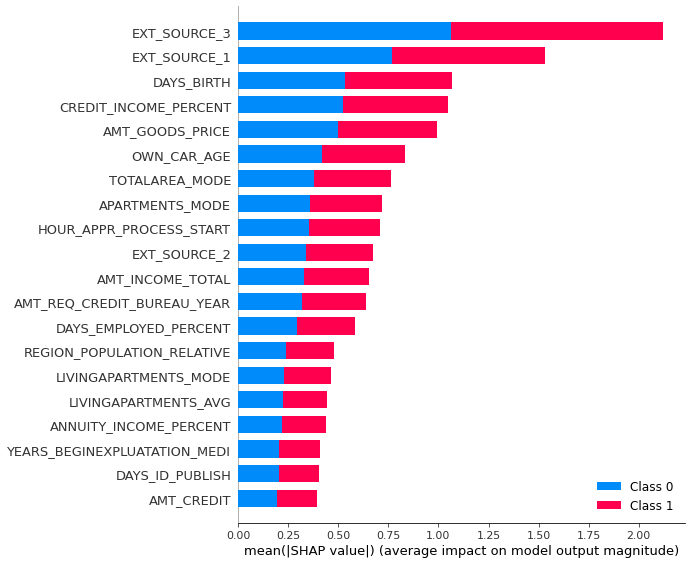

In [56]:
shap.summary_plot(shap_values, X_test_sample)

--interprétation du modéle pour les individus

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][120,:], X_test_sample.iloc[120], contribution_threshold=80)

In [68]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], X_test_sample.iloc[12])

In [67]:
pip freeze > requirements.txt 